# Model stats

In [1]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
# TODO SET ONCOLAB = TRUE IF WORKING ON COLAB
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/
  !ls

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/14nAfiUIlOkzENFAyByV5FH1KxQM8uSlm/CHALLENGE1
 01-Challenge.ipynb
 carpa.ipynb
'Copia di new_pipeline.ipynb'
 dataset.zip
 model.png
 new_pipeline.ipynb
 plotting.ipynb
 ResNet152V2_best_175_64_denselayerft_test210_weightOnClasses
 resnet50_best_128denselayerft_test140_weightOnClasses
 resnet_best_200denselayerft
 resnetv2_best_trained_on_test_200_denselayerft
 stats.ipynb
 training
 try_img_preproc.ipynb
 trySubmission.ipynb
 with_img_divided


In [4]:
# TODO CHANGE DATASET_PATH AND PATH_TO_MODEL AND PREPROCESSING FUNCTION
path_to_model = './resnet50_best_128denselayerft_test140_weightOnClasses'
dataset_path = './training'

batch_size = 128
validation_split = 0.3

def tl_preprocess(x):
  return tf.keras.applications.resnet50.preprocess_input(x)

In [5]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
img_h, img_w = (256, 256)

def load_data(dontUseFun=True, fun=None, isTest = False):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen

In [7]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [8]:
train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 12258 images belonging to 14 classes.
Found 5243 images belonging to 14 classes.


In [9]:
model = tf.keras.models.load_model(path_to_model)

## Visualize performance

In [10]:
labels = list(train_gen.class_indices.keys())

In [11]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_gen.classes, y_pred)

Confusion Matrix


In [12]:
print(cm)

[[ 221    1   10    0    4    0   13    5    0    0   18    0    0   14]
 [   0  127    2    0    0    0    0    5    0    0    1    0    0    0]
 [   0    0  142    0    2    0    0    0    0    0    2    0    0   24]
 [   0    0    1  356    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  430    0    0    0    0    0    0    1    0    1]
 [   0    0    0    0    0  510    3    0    0    0    0    0    0    6]
 [   1    0    0    0    0    0  286    1    0    0    0    0    0    0]
 [   0    0    0    1    0    0    5  214    0    0    0    0    0    5]
 [   1    0    0    0    0    0    0    2  192    0    3    0    0   12]
 [   0    0    0    0    4    0    0    0    0   70    0    0    0    0]
 [   1    0    1    0    0    0    0   10    4    0  450    0    0   14]
 [   0    0    0    0    0    0    0    0    0    0    0  167    0    0]
 [   1    0    0    0    0    0    0    1    4    1    0    0  188    2]
 [   2    0    4    1   19    0    1    5   24    7

In [13]:
!pip install seaborn

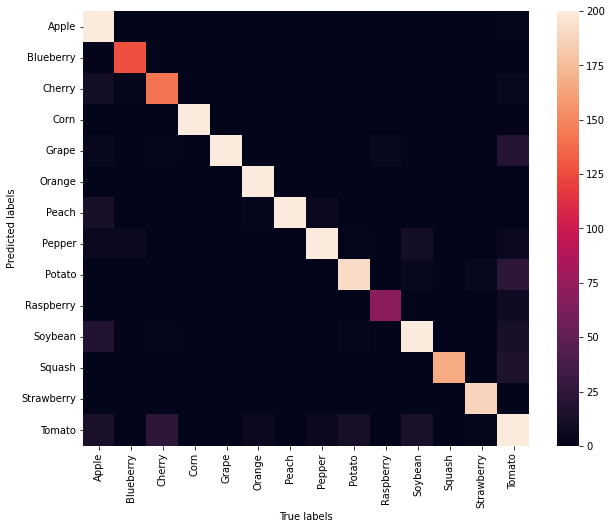

In [14]:
# Let's replot the heatmap but this time we put vmax = 200, so that tomatoes don't cloud the colors of the heatmap and we can visualize the distribution a bit better
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, vmax=200)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [15]:
# # Compute the classification metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = valid_gen.classes
predictions = Y_pred
accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.9468
Precision: 0.9381
Recall: 0.9404
F1: 0.9378


## Visualize model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 131072)            0         
                                                                 
 dropout_4 (Dropout)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                1806  

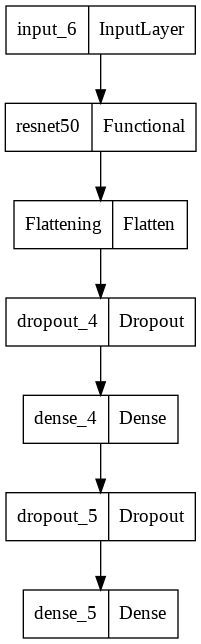

In [16]:
model.summary()
tfk.utils.plot_model(model)

In [20]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 5.1 MB/s 


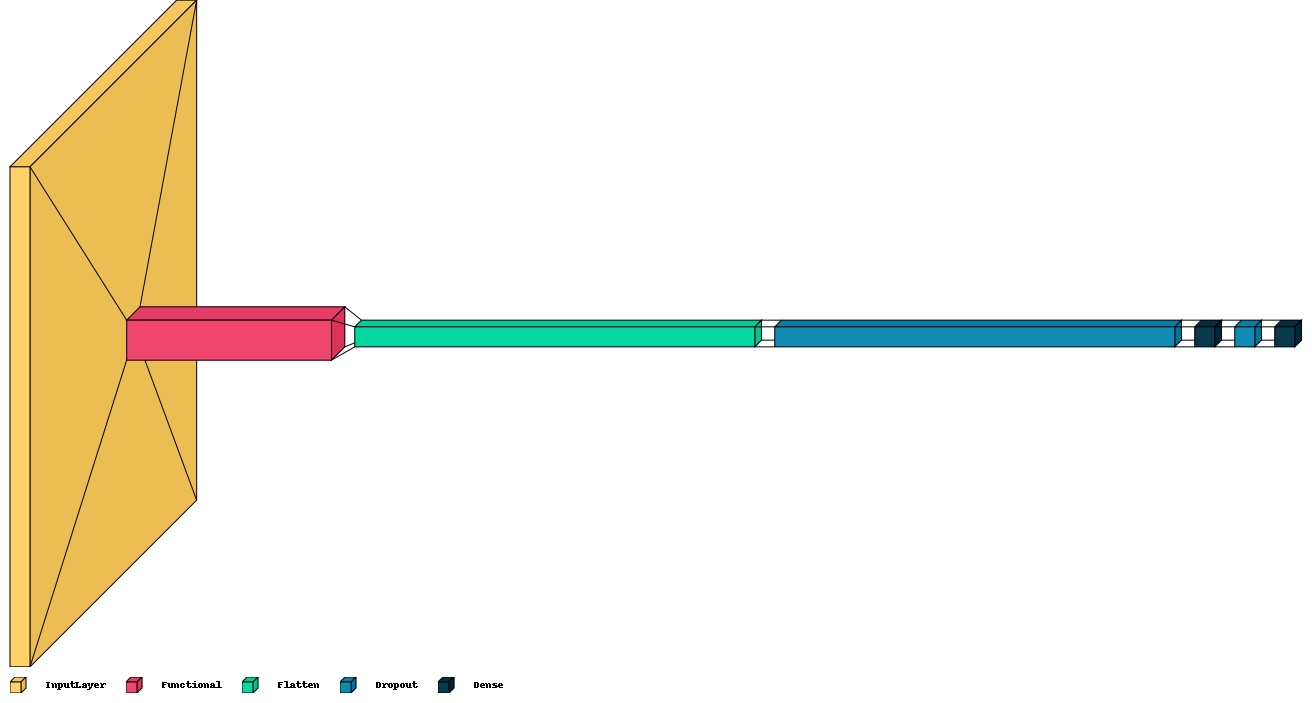

In [21]:
import visualkeras
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=5, max_xy=500)